In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from fenics import *
from algorithms.matrix_free_rsvd import MatrixFreeRSVD, get_approximate_W, tikhonov_solver
from algorithms.weighted_low_rank_solver import WeightedLowRankSolver
from utils.mesh_utils import get_square_f

/home/elias/miniforge3/envs/fenics_env/lib/python3.9/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [13]:
mesh = UnitSquareMesh(64, 64)
V_h = FunctionSpace(mesh, 'CG', 1)

rsvd = MatrixFreeRSVD(V_h)
x0, y0, width, height = 0., 0., 0.15, 0.15
f = get_square_f(V_h, x0, y0, w=width, h=height)
x = f.vector().get_local()
y = rsvd.apply_K(x)

k = 50
lambda_ = 1e-4
r_s = 1
alpha = 0.2
seed = None

[##############################] 5000/5000


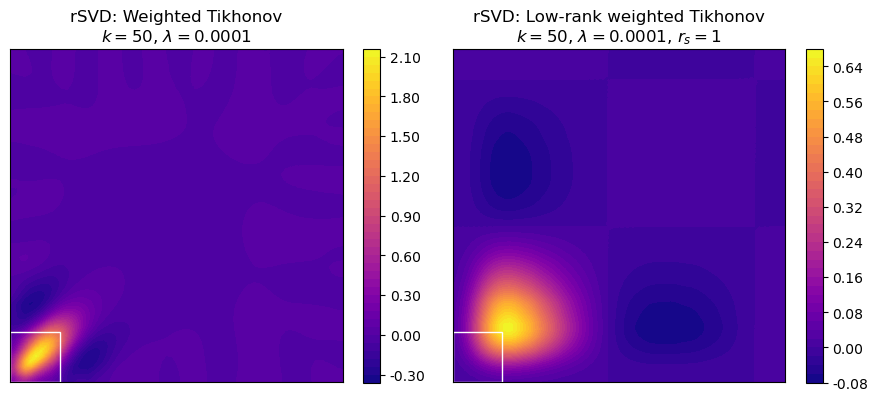

In [14]:
# Approximate SVD K = U S V^T and weights W
Uk, Sk, VkT = rsvd.mf_rsvd(k=k, seed=seed)
w = get_approximate_W(VkT.T, rsvd.M_dx)

# Weighted tikhonov solution
solver = WeightedLowRankSolver(
    V_h=V_h,
    M_dx=rsvd.M_dx,
    M_ds=rsvd.M_ds,
    U=Uk,
    S=Sk,
    VT=VkT,
)
x_tikhonov = tikhonov_solver(
    rsvd=rsvd,
    W_diag=w,
    y=y,
    lambda_=lambda_
)
f_tikhonov = Function(V_h)
f_tikhonov.vector()[:] = x_tikhonov

# Low-rank weighted tikhonov solution
f_low_rank = solver.solve(y,
    r_s=r_s,
    w=w,
    alpha=alpha,       # step size
    lambda_=lambda_,  # regularization param
    max_iter=5000,
    seed=seed
)

fig, axes = plt.subplots(1, 2, figsize=(9, 5))
ax1, ax2 = axes

plt.sca(ax1)
p = plot(f_tikhonov,
    title=f'rSVD: Weighted Tikhonov\n$k={k}$, $\\lambda={lambda_}$',
    cmap='plasma')
square = patches.Rectangle((x0, y0), width, height, edgecolor='white', facecolor='none')
ax1.add_patch(square)
fig.colorbar(p, ax=ax1, format="%.2f", shrink=0.71)
ax1.set_xticks([])
ax1.set_yticks([])

plt.sca(ax2)
p = plot(f_low_rank,
    title=f'rSVD: Low-rank weighted Tikhonov\n$k={k}$, $\\lambda={lambda_}$, $r_s={r_s}$',
    cmap='plasma')
square = patches.Rectangle((x0, y0), width, height, edgecolor='white', facecolor='none')
ax2.add_patch(square)
fig.colorbar(p, ax=ax2, format="%.2f", shrink=0.71)
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()